In [1]:
# Most of the code is from https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html

import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets

import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

In [3]:
import os

In [4]:
batch_size = 128
num_epochs = 20
device = torch.device("cpu")

dataset = 'CIFAR'

# options are MNIST and CIFAR

In [5]:
def train(model, device, train_loader, optimizer, criterion, dataset, epoch):

    print(f'Training {dataset}')
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if dataset == 'CIFAR':
            loss = criterion(output, target)
        elif dataset == 'MNIST':
            loss = criterion(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
            
    return model


def test(model, device, criterion, dataset, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if dataset == 'MNIST':
                test_loss += criterion(output.log(), target).item()  # sum up batch loss
            elif dataset == 'CIFAR':
                test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[
                1
            ]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

In [6]:
if dataset == 'CIFAR':

    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool1 = nn.MaxPool2d(2, 2)
            self.pool2 = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)
            self.relu1 = nn.ReLU()
            self.relu2 = nn.ReLU()
            self.relu3 = nn.ReLU()
            self.relu4 = nn.ReLU()
    
        def forward(self, x):
            x = self.pool1(self.relu1(self.conv1(x)))
            x = self.pool2(self.relu2(self.conv2(x)))
            x = x.view(-1, 16 * 5 * 5)
            x = self.relu3(self.fc1(x))
            x = self.relu4(self.fc2(x))
            x = self.fc3(x)
            return x

    criterion = nn.CrossEntropyLoss()

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                              shuffle=True, num_workers=2)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=128,
                                             shuffle=False, num_workers=2)
    
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    if os.path.isfile(f'captum-models/CIFAR.pth'):

        checkpoint = f'captum-models/CIFAR.pth'

        model.load_state_dict(torch.load(checkpoint))

        model.eval()

        print(f'evaluation')

    else:
    
        for epoch in range(1, num_epochs + 1):
            model = train(model, device, train_loader, optimizer, criterion, dataset, epoch)
            test(model, device, criterion, dataset, test_loader)
            
        torch.save(model.state_dict(), f'captum-models/CIFAR.pth')

elif dataset == 'MNIST':

    criterion = nn.NLLLoss()

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            "data",
            train=True,
            download=True,
            transform=transforms.Compose([transforms.ToTensor()]),
        ),
        batch_size=batch_size,
        shuffle=True,
    )
    
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            "data", train=False, transform=transforms.Compose([transforms.ToTensor()])
        ),
        batch_size=batch_size,
        shuffle=True,
    )


    class Net(nn.Module):
        def __init__(self):
            super().__init__()
    
            self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 10, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(10, 20, kernel_size=5),
                nn.Dropout(),
                nn.MaxPool2d(2),
                nn.ReLU(),
            )
            self.fc_layers = nn.Sequential(
                nn.Linear(320, 50),
                nn.ReLU(),
                nn.Dropout(),
                nn.Linear(50, 10),
                nn.Softmax(dim=1),
            )
    
        def forward(self, x):
            x = self.conv_layers(x)
            x = x.view(-1, 320)
            x = self.fc_layers(x)
            return x

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    if os.path.isfile(f'captum-models/MNIST.pth'):

        checkpoint = f'captum-models/MNIST.pth'

        model.load_state_dict(torch.load(checkpoint))

        model.eval()

        print(f'evaluation')

    else:
    
        for epoch in range(1, num_epochs + 1):
            model = train(model, device, train_loader, optimizer, criterion, dataset, epoch)
            test(model, device, criterion, dataset, test_loader)
            
        torch.save(model.state_dict(), f'captum-models/MNIST.pth')

Files already downloaded and verified
Files already downloaded and verified
evaluation


In [7]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:103]

In [8]:
background.shape

torch.Size([100, 3, 32, 32])

In [9]:
model(background).shape

torch.Size([100, 10])

In [10]:
e = shap.DeepExplainer(model, background)

In [11]:
shap_values = e.shap_values(test_images)

In [12]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

In [13]:
test_numpy.shape

(3, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


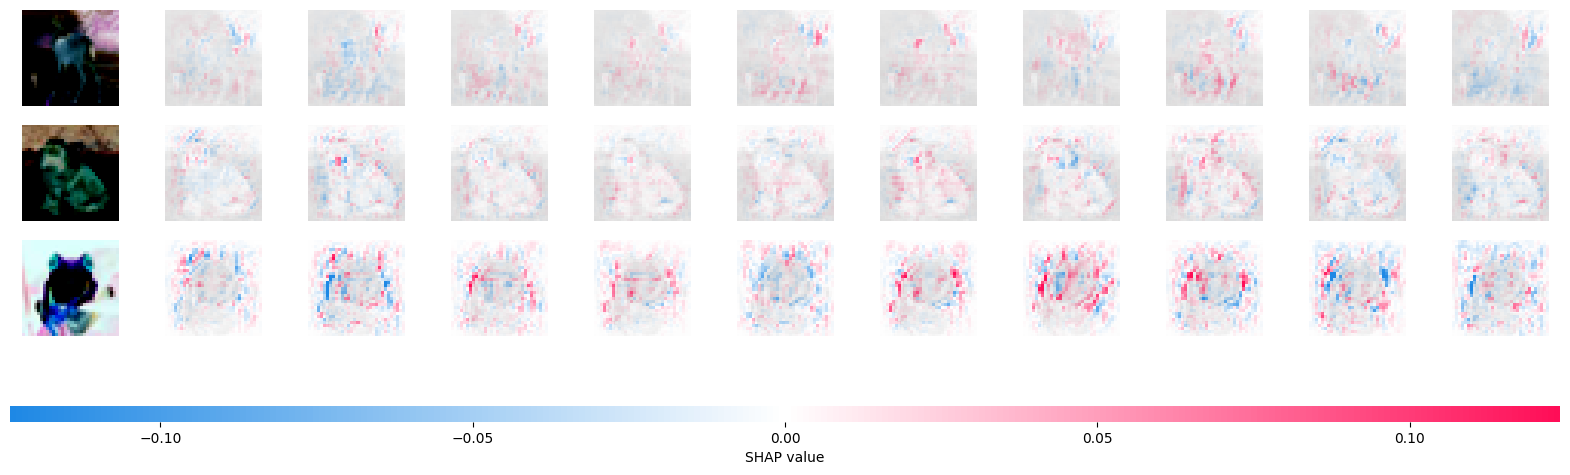

In [14]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)
